# Session 1: Workflow and ML Regression

## Getting started

First, we will load the packages we need for these exercises.

In [1]:
# This line is needed to force matplotlib to display inline in the notebook
%matplotlib inline

import pickle

# The 3 lines below here suppress ConvergenceWarnings -- this is not necessarily something
# I would recommend doing in practice, but avoids spammed warnings in a particular cell
# towards the end of this file
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

import pandas as pd                        # Work with data frames
import numpy as np                         # Simple mathematics function and linear algebra
import matplotlib.pyplot as plt            # Charting functions
plt.rcParams['figure.figsize'] = [12, 8]   # Make plots larger by default
import statsmodels.formula.api as smf      # Basic econometric regressions
from sklearn import model_selection        # Training and testing splits
from sklearn import linear_model           # GLM-type models -- both econometric and ML
from sklearn import metrics                # Model performance evaluation
from sklearn import preprocessing          # For standardizing data for LASSO and Elastic net

Next, we need to import the dataset for the sessions exercises.

While the original csv file is ~38MB, the gzipped version is only 17MB.  Using gzipped (or zipped) files is a good way to save storage space while working with csv files in Python (and in R as well).

In [2]:
df = pd.read_csv('../../Data/S1_data.csv.gz')

We will also define some lists out of convenience for later:

In [3]:
vars_financial = ['logtotasset', 'rsst_acc', 'chg_recv', 'chg_inv', 'soft_assets', 'pct_chg_cashsales', 'chg_roa',
                  'issuance', 'oplease_dum', 'book_mkt', 'lag_sdvol', 'merger', 'bigNaudit', 'midNaudit', 'cffin',
                  'exfin', 'restruct']
vars_style = ['bullets', 'headerlen', 'newlines', 'alltags', 'processedsize', 'sentlen_u', 'wordlen_s', 'paralen_s',
              'repetitious_p', 'sentlen_s', 'typetoken', 'clindex', 'fog', 'active_p', 'passive_p', 'lm_negative_p',
              'lm_positive_p', 'allcaps', 'exclamationpoints', 'questionmarks']
vars_topic = ['Topic_' + str(i+1) + '_n_oI' for i in range(0,31)]

Below I have also defined some custom functions.  Don't worry about these until we get to using them.

In [4]:
def coefplot(names, coef, title=None):
    # Make sure coef is list, cast to list if needed.
    if isinstance(coef, np.ndarray):
        if len(coef.shape) > 1:
            coef = list(coef[0])
        else:
            coef = list(coef)
    
    # Drop unneeded vars
    data = []
    for i in range(0, len(coef)):
        if coef[i] != 0:
            data.append([names[i], coef[i]])
    data.sort(key=lambda x: x[1])
    
    # Add in a key for the plot axis
    data = [data[i] + [i+1] for i in range(0,len(data))]
    
    fig, ax = plt.subplots(figsize=(4,0.25*len(data)))

    ax.scatter([i[1] for i in data], [i[2] for i in data])
    
    ax.grid(axis='y')
    ax.set(xlabel="Fitted value", ylabel="Residual", title=(title if title is not None else "Coefficient Plot"))
    
    ax.axvline(x=0, linestyle='dotted')
    ax.set_yticks([i[2] for i in data])
    ax.set_yticklabels([i[0] for i in data])
    
    return ax

In [5]:
def lasso_coefpath(model, X, Y):
    if 'alphas_' in dir(model):
        alphas = reg_lasso.alphas_
        coefs = []
        for a in alphas:
            temp_lasso = linear_model.Lasso(alpha=a, warm_start=True)
            temp_lasso.fit(X, Y)
            coefs.append(temp_lasso.coef_)

        fig, ax = plt.subplots()

        ax.plot(alphas, coefs)
        ax.set_xscale('log')
        ax.set_xlim(ax.get_xlim()[::-1])
        ax.set_xlabel("alpha")
        ax.set_ylabel("Coefficient values")
        
        return ax
    elif 'Cs_' in dir(model):
        Cs = reg_lasso.Cs_
        coefs = []
        for c in Cs:
            temp_lasso = linear_model.LogisticRegression(penalty='l1', solver='saga', C=c, warm_start=True)
            temp_lasso.fit(X, Y)
            coefs.append(temp_lasso.coef_[0])

        fig, ax = plt.subplots()

        ax.plot(Cs, coefs)
        ax.set_xscale('log')
        ax.set_xlabel("C")
        ax.set_ylabel("Coefficient values")
        
        return ax
    else:
        print("Does not match linear_model.LassoCV or linear_model.LogisticRegressionCV")
        return False

In [6]:
def lasso_scorepath(model, errorbars=True):
    if 'alphas_' in dir(model):
        alphas = reg_lasso.alphas_
        mean = np.mean(reg_lasso.mse_path_, axis=1)
        std = np.std(reg_lasso.mse_path_, axis=1)*1.96

        fig, ax = plt.subplots()
        
        if errorbars:
            ax.errorbar(alphas, mean, yerr=std, ecolor="lightgray", elinewidth=2, capsize=4, capthick=2)
        else:
            ax.plot(alphas, mean)
        ax.set_xscale('log')
        ax.set_xlabel("alpha")
        ax.set_ylabel("Mean Squared error")
        
        return ax
    elif 'Cs_' in dir(model):
        Cs = reg_lasso.Cs_
        mean = np.mean(reg_lasso.scores_[1], axis=0)
        std = np.std(reg_lasso.scores_[1], axis=0)*1.96

        fig, ax = plt.subplots()
        
        if errorbars:
            ax.errorbar(Cs, mean, yerr=std, ecolor="lightgray", elinewidth=2, capsize=4, capthick=2)
        else:
            ax.plot(Cs, mean)
        ax.set_xscale('log')
        ax.set_xlabel("C")
        ax.set_ylabel("ROC AUC")
        
        return ax
    else:
        print("Does not match linear_model.LassoCV or linear_model.LogisticRegressionCV")
        return False

### Splitting samples into training and testing

There are multiple ways to do this.  The most robust is to separate the training and testing samples by time.  We can do this using the techniques taught in part 1.

In [7]:
# Check the years in the data
df['year'].unique()

array([2002, 2003, 2004, 1999, 2000, 2001], dtype=int64)

In [8]:
# Subset the final year to be the testing year
train = df[df.year < 2004]
test = df[df.year == 2004]
print(df.shape, train.shape, test.shape)

(14301, 198) (11478, 198) (2823, 198)


The second approach is to randomly assign observations into the training and testing samples.  This is a reasonable choice if *predictive* performance is not the primary goal of the analysis, or if the data is all from the same point in time. This can be done simply by using scikit-learn.  Note that scikit-learn expects the DVs and IVs to be in separate dataframes, so we will need to do this first.

In [9]:
Y1 = df['sdvol1']
X1 = df.drop(columns=['sdvol1'])

In [10]:
# test_size specifies the percent of the files to hold for testing
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X1, Y1, test_size=0.2)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(11440, 197) (2861, 197) (11440,) (2861,)


## Regressions with statsmodels

### Linear regression

First, we will try a simple linear regression using statsmodels to replicate a replication of Bao and Datta (2014) from Brown, Crowley and Elliott (2020) (henceforth BCE).  This is simply a linear regression of future stock return volatility, `sdvol1`, on the topic measures from the BCE study.

We will use this as a stepping stone to get to the LASSO model.

Like with R, statsmodels' equation interface is quite flexible.  For instance, we can apply functions like `np.log()` inside the equation, we can store the equation in a variable and simple pass the variable instead, or we can make the equation programmatically on the fly (as we will see with the last model).

Here we define a the formula programmatically so as to keep things both succinct and easy to extend.

In [11]:
formula = 'sdvol1 ~ ' + ' + '.join(vars_topic[0:-1])  # Drop the final value to avoid multicollinearity
formula

'sdvol1 ~ Topic_1_n_oI + Topic_2_n_oI + Topic_3_n_oI + Topic_4_n_oI + Topic_5_n_oI + Topic_6_n_oI + Topic_7_n_oI + Topic_8_n_oI + Topic_9_n_oI + Topic_10_n_oI + Topic_11_n_oI + Topic_12_n_oI + Topic_13_n_oI + Topic_14_n_oI + Topic_15_n_oI + Topic_16_n_oI + Topic_17_n_oI + Topic_18_n_oI + Topic_19_n_oI + Topic_20_n_oI + Topic_21_n_oI + Topic_22_n_oI + Topic_23_n_oI + Topic_24_n_oI + Topic_25_n_oI + Topic_26_n_oI + Topic_27_n_oI + Topic_28_n_oI + Topic_29_n_oI + Topic_30_n_oI'

In [12]:
model = smf.ols(formula=formula, data=train)
fit_ols = model.fit()
fit_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 sdvol1   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     73.45
Date:                Sun, 18 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:51:27   Log-Likelihood:                 24508.
No. Observations:               11478   AIC:                        -4.895e+04
Df Residuals:                   11447   BIC:                        -4.873e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0458      0.000    171.114      0.000       0.045       0.046
Topic_1_n_oI      1.1709      0.340      3.440      0.001       0.504       1.838
Topic_2_n_oI      0.5367      0.262      2.052      0.040       0.024       1.049
Topic_3_n_oI      0.4004      0.416      0.963      0.336      -0.415       1.216
Topic_4_n_oI      0.6475      0.239      2.713      0.007       0.180       1.115
Topic_5_n_oI      0.6777      0.246      2.752      0.006       0.195       1.160
Topic_6_n_oI      0.5422      0.363      1.494      0.135      -0.169       1.254
Topic_7_n_oI     -0.6519      0.286     -2.281      0.023      -1.212      -0.092
Topic_8_n_oI      0.5089      0.253      2.012      0.044       0.013       1.005
Topic_9_n_oI      2.1940      0.225      9.772      0.000       1.754       2.634
Topic_10_n_oI     0.6722      0.207      3.242      0.001       0.266       1.079
Topic_11_n_oI    -1.2180      0.259     -4.696      0.000      -1.726      -0.710
Topic_12_n_oI    -0.0311      0.295     -0.105      0.916      -0.609       0.547
Topic_13_n_oI     0.5372      0.811      0.662      0.508      -1.053       2.127
Topic_14_n_oI    -1.9815      0.279     -7.113      0.000      -2.528      -1.435
Topic_15_n_oI     0.7315      0.191      3.832      0.000       0.357       1.106
Topic_16_n_oI    -1.8828      0.447     -4.214      0.000      -2.759      -1.007
Topic_17_n_oI    -0.2011      0.339     -0.593      0.553      -0.866       0.463
Topic_18_n_oI     1.9874      0.375      5.305      0.000       1.253       2.722
Topic_19_n_oI     1.4410      0.232      6.208      0.000       0.986       1.896
Topic_20_n_oI    -1.5943      0.368     -4.330      0.000      -2.316      -0.873
Topic_21_n_oI     2.9559      0.338      8.737      0.000       2.293       3.619
Topic_22_n_oI     0.8334      0.205      4.065      0.000       0.431       1.235
Topic_23_n_oI     0.1696      0.213      0.797      0.426      -0.248       0.587
Topic_24_n_oI     0.6900      0.245      2.812      0.005       0.209       1.171
Topic_25_n_oI     0.7991      0.213      3.743      0.000       0.381       1.218
Topic_26_n_oI     0.5921      0.206      2.878      0.004       0.189       0.995
Topic_27_n_oI     1.5067      0.576      2.617      0.009       0.378       2.635
Topic_28_n_oI     1.2985      0.263      4.928      0.000       0.782       1.815
Topic_29_n_oI     0.6241      0.200      3.125      0.002       0.233       1.016
Topic_30_n_oI    -0.4546      0.465     -0.979      0.328      -1.365       0.456
==============================================================================
Omnibus:                     8439.589   Durbin-Watson:                   1.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           291613.425
Skew:                           3.157   Prob(JB):         

### Logistic regression

Statsmodels supports many other types of regression, including logistic, probit, and Poisson, among others.  A full list of supported types for your installed version of statsmodels can be found by running the below code:

In [13]:
print('Supported regression types include: ' + ', '.join([i for i in dir(smf) if '_' not in i ]))

Supported regression types include: gee, glm, glmgam, gls, glsar, logit, mixedlm, mnlogit, negativebinomial, ols, phreg, poisson, probit, quantreg, rlm, wls


For the logistic regression example, we will run a single window of the intentional restatement prediction test from BCE.  All we need to do is use a different formula function from statsmodels and update our formula to match our desired equation.

In [14]:
formula = 'Restate_Int ~ ' + \
          ' + '.join(vars_financial) + ' + ' +\
          ' + '.join(vars_style) + ' + ' +\
          ' + '.join(vars_topic[0:-1])  # Drop the final value to avoid multicollinearity
model = smf.logit(formula=formula, data=train)
fit_logit = model.fit()
fit_logit.summary()

         Current function value: 0.054196
         Iterations: 35


M:\Python_environments\miniconda\envs\MLSS\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
M:\Python_environments\miniconda\envs\MLSS\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
M:\Python_environments\miniconda\envs\MLSS\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Restate_Int   No. Observations:                11478
Model:                          Logit   Df Residuals:                    11410
Method:                           MLE   Df Model:                           67
Date:                Sun, 18 Aug 2024   Pseudo R-squ.:                  0.1205
Time:                        14:51:35   Log-Likelihood:                -622.06
converged:                      False   LL-Null:                       -707.27
Covariance Type:            nonrobust   LLR p-value:                 5.753e-11
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -6.6337      5.591     -1.187      0.235     -17.592       4.324
logtotasset           0.0936      0.064      1.454      0.146      -0.033       0.220
rsst_acc              0.3269      0.323      1.013      0.311      -0.305       0.959
chg_recv              0.6838      1.307      0.523      0.601      -1.878       3.245
chg_inv              -1.4284      1.509     -0.947      0.344      -4.386       1.529
soft_assets           1.4508      0.470      3.088      0.002       0.530       2.371
pct_chg_cashsales    -0.0012      0.008     -0.145      0.885      -0.018       0.015
chg_roa              -0.2584      0.263     -0.981      0.327      -0.775       0.258
issuance              0.2336      0.422      0.554      0.580      -0.593       1.060
oplease_dum           0.1529      0.314      0.488      0.626      -0.462       0.768
book_mkt              0.0080      0.044      0.180      0.857      -0.079       0.095
lag_sdvol            -0.0400      0.100     -0.399      0.690      -0.237       0.157
merger               -0.2662      0.256     -1.039      0.299      -0.769       0.236
bigNaudit            -0.1544      0.445     -0.347      0.729      -1.027       0.718
midNaudit             0.3926      0.522      0.752      0.452      -0.630       1.415
cffin                 0.5806      0.297      1.954      0.051      -0.002       1.163
exfin                -0.0202      0.024     -0.834      0.404      -0.068       0.027
restruct              0.6353      0.216      2.945      0.003       0.212       1.058
bullets            1.075e-05   3.48e-05      0.309      0.757   -5.74e-05    7.89e-05
headerlen          2.224e-05      0.000      0.197      0.844      -0.000       0.000
newlines             -0.0003      0.000     -1.599      0.110      -0.001    7.62e-05
alltags            -1.43e-07    2.8e-07     -0.511      0.610   -6.92e-07    4.06e-07
processedsize      5.323e-06   1.84e-06      2.893      0.004    1.72e-06    8.93e-06
sentlen_u            -0.0980      0.111     -0.884      0.377      -0.315       0.119
wordlen_s             0.9048      2.063      0.438      0.661      -3.139       4.949
paralen_s             0.0462      0.021      2.179      0.029       0.005       0.088
repetitious_p         1.5938      1.984      0.803      0.422      -2.295       5.482
sentlen_s            -0.0323      0.031     -1.053      0.292      -0.092       0.028
typetoken            -8.3850      3.526     -2.378      0.017     -15.295      -1.475
clindex              -0.3223      0.246     -1.310      0.190      -0.805       0.160
fog                   0.2704      0.231      1.170      0.242      -0.183       0.723
active_p             -0.8746      2.264     -0.386      0.699      -5.312       3.562
passive_p             4.6649      3.770      1.238      0.216      -2.723      12.053
lm_negative_p        92.0693     18.403      5.003      0.000      55.999     128.139
lm_positive_p       -43.0639     64.547     -0.667      0.5

### Estimating how well a model works

For in-sample prediction, we can apply the `.predict()` method to our current data.  For out-of-sample prediction, we can likewise apply `.predict()` to our testing data.

What we really want are quantitative measures of how well a model works.  For that, scikit-learn is very handy.  In sklearn.metrics there are a ton of measures available including Mean Squared Error (square of RMSE), Mean Absolute Error (MAE), NDCG@k, and ROC AUC.

We will check in-sample and out-of-sample scores for the following:

- RMSE and MAE for the linear regression
- ROC AUC for the logistic regression

In [15]:
# Linear, in-sample
Y_hat_train = fit_ols.predict(train)

# squared=False means this function will return RMSE instead of MSE.
rmse = metrics.mean_squared_error(train.sdvol1, Y_hat_train, squared=False)
mae = metrics.mean_absolute_error(train.sdvol1, Y_hat_train)

print('RMSE: {:.4f}, MAE: {:.4f}'.format(rmse, mae))

RMSE: 0.0286, MAE: 0.0191


In [16]:
# Linear, out-of-sample
Y_hat_test = fit_ols.predict(test)

# squared=False means this function will return RMSE instead of MSE.
rmse = metrics.mean_squared_error(test.sdvol1, Y_hat_test, squared=False)
mae = metrics.mean_absolute_error(test.sdvol1, Y_hat_test)

print('RMSE: {:.4f}, MAE: {:.4f}'.format(rmse, mae))

RMSE: 0.0223, MAE: 0.0188


As seen above, performance out-of-sample is quite similar to performance in-sample for predicting stock market volatility.  This is a good sign for our model.

In [17]:
# Logit, in-sample
Y_hat_train = fit_logit.predict(train)

auc = metrics.roc_auc_score(train.Restate_Int, Y_hat_train)

print('ROC AUC: {:.4f}'.format(auc))

ROC AUC: 0.7795


M:\Python_environments\miniconda\envs\MLSS\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


We can also plot out an ROC curve by calculating the True Positive rate and False Positive Rate.  We can use `metrics.roc_curve()` to calculate these.  Then we can display the curve using `metrics.RocCurveDisplay()`.  Note that the function `metrics.plot_roc_curve()` used to exist, and worked with models run in scikit-learn itself.  This is now rolled into `metrics.RocCurveDisplay()`.

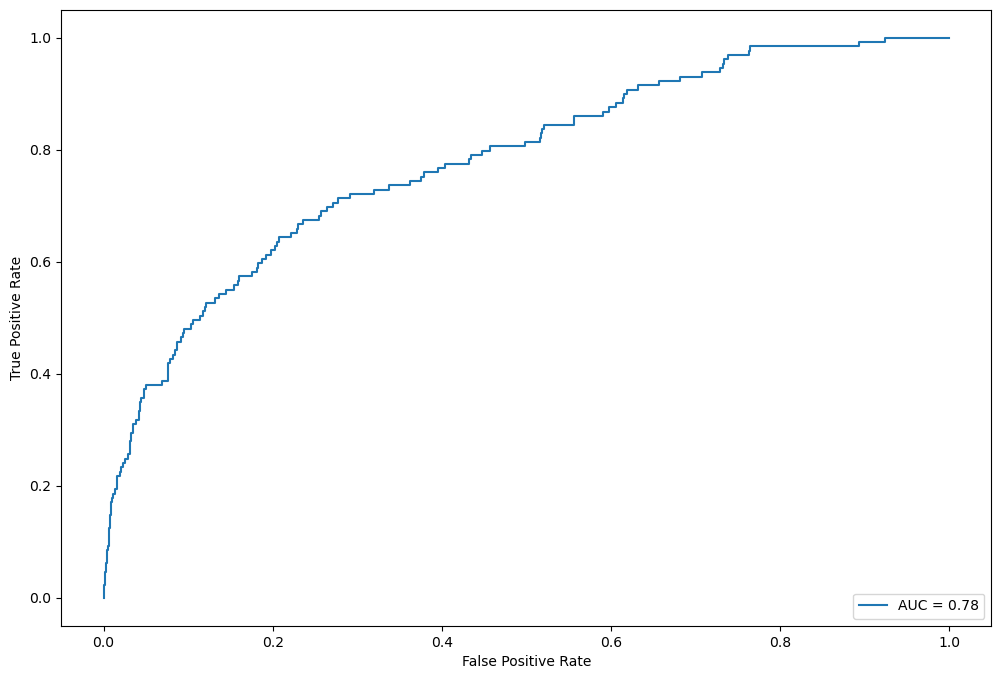

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(train.Restate_Int, Y_hat_train)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
display.plot()

ROC AUC: 0.6093


M:\Python_environments\miniconda\envs\MLSS\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


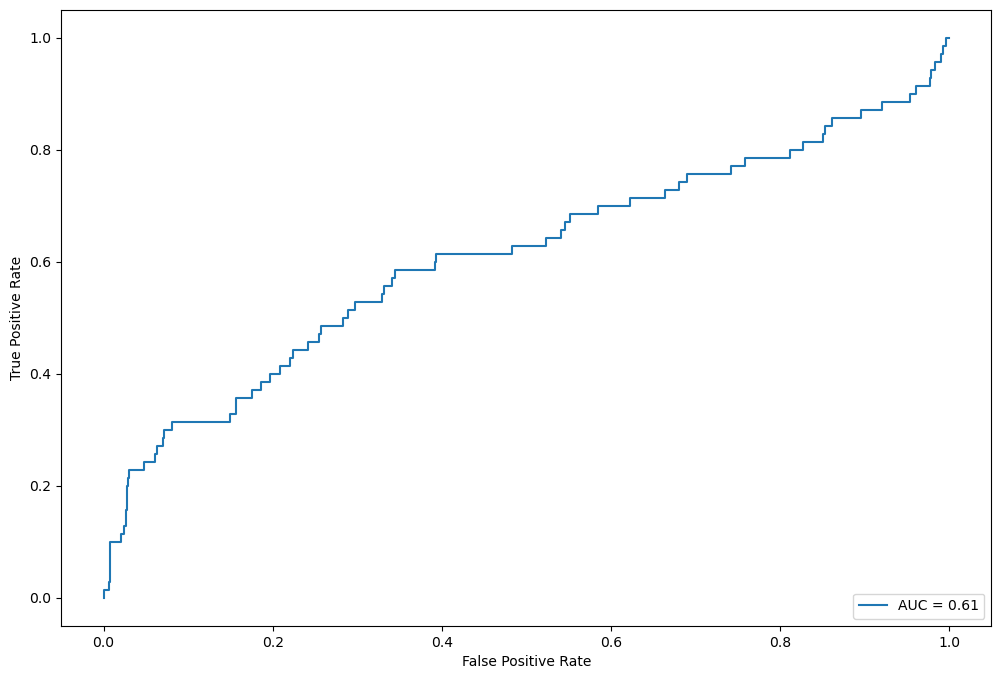

In [19]:
# Logit, out-of-sample
Y_hat_test = fit_logit.predict(test)

auc = metrics.roc_auc_score(test.Restate_Int, Y_hat_test)

print('ROC AUC: {:.4f}'.format(auc))

fpr, tpr, thresholds = metrics.roc_curve(test.Restate_Int, Y_hat_test)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
display.plot()

## Using machine learning for regression

One of the simplest machine learning approaches to implement is LASSO.  LASSO is available in scikit learn as part of the `sklearn.linear_model`.  LASSO is not far removed from the OLS and logistic regressions we have seen -- the only difference between them is that LASSO adds an L1-norm penalty based on the coefficients in the model.  More specifically, the penalty is the sum of the absolute values of the model coefficients times a penalty parameter.

Because there is a new parameter though, we can't simply solve by minimizing the sum of squared error!  Instead, we'll need to also provide a value for the parameter, or ideally optimize it.

We will start by re-running our above analyses with a pre-specified value of $\alpha=0.1$ and $C=0.1$.

### Linear regression with  LASSO

In [20]:
# Set up the data for the regression
vars = vars_topic
scaler_X = preprocessing.StandardScaler()
scaler_X.fit(train[vars])
train_X_linear = scaler_X.transform(train[vars])
test_X_linear = scaler_X.transform(test[vars])

scaler_Y = preprocessing.StandardScaler()
scaler_Y.fit(np.array(train.sdvol1).reshape(-1, 1))
train_Y_linear = scaler_Y.transform(np.array(train.sdvol1).reshape(-1, 1))
test_Y_linear = scaler_Y.transform(np.array(test.sdvol1).reshape(-1, 1))

In [21]:
reg_lasso = linear_model.Lasso(alpha=0.1)
reg_lasso.fit(train_X_linear, train_Y_linear)

Lasso(alpha=0.1)

Unforetunately, scikit-learn's functions lack a tidy summary of the results.  As such, we need to code our own summary.  Below are two possibilities.  The first simply lists the variables and their respective coefficient.  The second summarizes the same output, but plots the coefficients from most negative to most positive, aiming to make interpretation a bit easier.  This is more or less a reworking of the `glmnet` integration the `coefplot` library has in R.  The code for this function is at the top of this file.

In [22]:
print('\n'.join([str(i) for i in zip(vars, list(reg_lasso.coef_))]))

('Topic_1_n_oI', 0.0)
('Topic_2_n_oI', -0.0)
('Topic_3_n_oI', -0.0)
('Topic_4_n_oI', 0.0)
('Topic_5_n_oI', 0.0)
('Topic_6_n_oI', -0.0)
('Topic_7_n_oI', -0.024652670717253942)
('Topic_8_n_oI', 0.0)
('Topic_9_n_oI', 0.0025216975893077123)
('Topic_10_n_oI', -0.0)
('Topic_11_n_oI', -0.040763790800078754)
('Topic_12_n_oI', 0.014243533618840738)
('Topic_13_n_oI', -0.0)
('Topic_14_n_oI', -0.11823748613317225)
('Topic_15_n_oI', -0.0)
('Topic_16_n_oI', -0.01911103294642791)
('Topic_17_n_oI', -0.0)
('Topic_18_n_oI', 0.023019539743958616)
('Topic_19_n_oI', 0.0)
('Topic_20_n_oI', -0.0)
('Topic_21_n_oI', 0.05362218975734817)
('Topic_22_n_oI', -0.0)
('Topic_23_n_oI', -0.0)
('Topic_24_n_oI', -0.0)
('Topic_25_n_oI', 0.0)
('Topic_26_n_oI', 0.0)
('Topic_27_n_oI', -0.0)
('Topic_28_n_oI', 0.0)
('Topic_29_n_oI', 0.0)
('Topic_30_n_oI', -0.0)
('Topic_31_n_oI', 0.0)


<Axes: title={'center': 'Coefficient Plot'}, xlabel='Fitted value', ylabel='Residual'>

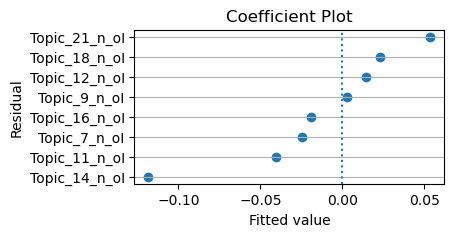

In [23]:
coefplot(vars, reg_lasso.coef_)

### Logistic Regression with LASSO

In [24]:
# Set up the data for the regression
vars = vars_topic + vars_financial + vars_style
scaler_X = preprocessing.StandardScaler()
scaler_X.fit(train[vars])
train_X_logistic = scaler_X.transform(train[vars])
test_X_logistic = scaler_X.transform(test[vars])

train_Y_logistic = train.Restate_Int
test_Y_logistic = test.Restate_Int

In [25]:
reg_lasso = linear_model.LogisticRegression(penalty='l1', solver='saga', C=0.1)
reg_lasso.fit(train_X_logistic, train_Y_logistic)

LogisticRegression(C=0.1, penalty='l1', solver='saga')

Unforetunately, scikit-learn's functions lack a tidy summary of the results.  As such, we need to code our own summary.  Below are two possibilities.  The first simply lists the variables and their respective coefficient.  The second summarizes the same output, but plots the coefficients from most negative to most positive, aiming to make interpretation a bit easier.  This is more or less a reworking of the `glmnet` integration the `coefplot` library has in R.  The code for this function is at the top of this file.

In [26]:
print('\n'.join([str(i) for i in zip(vars, list(reg_lasso.coef_[0]))]))

('Topic_1_n_oI', -0.02401951817687689)
('Topic_2_n_oI', 0.0)
('Topic_3_n_oI', 0.0)
('Topic_4_n_oI', 0.0)
('Topic_5_n_oI', 0.0)
('Topic_6_n_oI', 0.0)
('Topic_7_n_oI', 0.0)
('Topic_8_n_oI', -0.00011446989401755379)
('Topic_9_n_oI', 0.0)
('Topic_10_n_oI', 0.0)
('Topic_11_n_oI', -0.04063977361390532)
('Topic_12_n_oI', -0.018553630846251033)
('Topic_13_n_oI', 0.0)
('Topic_14_n_oI', 0.0)
('Topic_15_n_oI', 0.003984755578627834)
('Topic_16_n_oI', 0.0)
('Topic_17_n_oI', -0.005828167243392166)
('Topic_18_n_oI', 0.0)
('Topic_19_n_oI', -0.013464017477491538)
('Topic_20_n_oI', 0.0)
('Topic_21_n_oI', 0.0)
('Topic_22_n_oI', -0.006800735422139787)
('Topic_23_n_oI', 0.049673400120208565)
('Topic_24_n_oI', 0.0)
('Topic_25_n_oI', 0.052078936748758756)
('Topic_26_n_oI', 0.0)
('Topic_27_n_oI', 0.0)
('Topic_28_n_oI', -0.026352104376884)
('Topic_29_n_oI', 0.0)
('Topic_30_n_oI', 0.0)
('Topic_31_n_oI', -0.0025716718804047536)
('logtotasset', 0.0108753168614137)
('rsst_acc', 0.0)
('chg_recv', 0.0)
('chg_inv', 0

<Axes: title={'center': 'Coefficient Plot'}, xlabel='Fitted value', ylabel='Residual'>

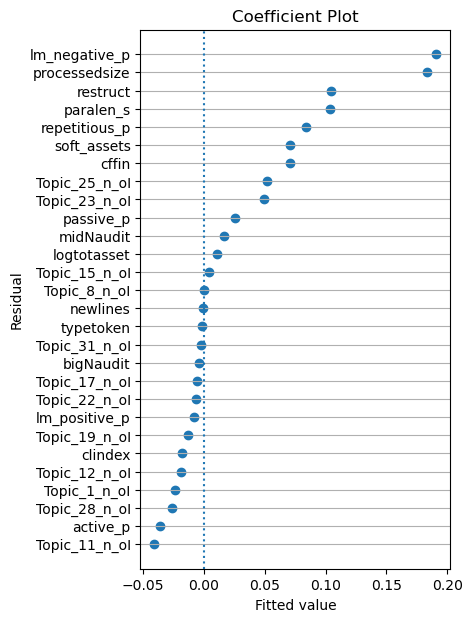

In [27]:
coefplot(vars, reg_lasso.coef_)

Note how many variables were dropped in the above regression!  This is a manifestation of the "Selection" part of LASSO.

### Optimizing the LASSO parameter -- Linear regression

Using cross-validation is built right into scikit-learn.  We can simply call the correspondingly tweaked function, tell it how many folds we want, and let it optimize!

For linear LASSO, the cross-validation approach will optimize $R^2$.  If this is not your target, then you would need to build your own CV method (e.g., using scikit-learn's inbuilt GridSearch 

In [28]:
reg_lasso = linear_model.LassoCV(cv=10)
reg_lasso.fit(train_X_linear, np.ravel(train_Y_linear))
print('The alpha that optimizes R^2 is: {}'.format(reg_lasso.alpha_))

The alpha that optimizes R^2 is: 0.018778122679424136


<Axes: title={'center': 'Coefficient Plot'}, xlabel='Fitted value', ylabel='Residual'>

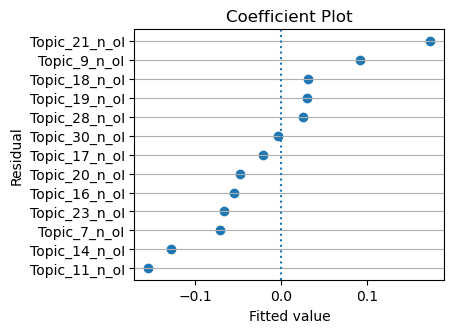

In [29]:
coefplot(vars, reg_lasso.coef_)

To see what exactly was going on in the CV routine above, we can replicate the LASSO output at each alpha it tested.  The below code does this and then plots a graph showing how, as the penatly alpha increases, coefficients converge to 0.

To this end, I have provided two custom functions in this notebook: `lasso_coefpath()` and `lasso_scorepath()`.  The first function allows you to visualize how the coefficients on each IV change as the penalty changes.  The second function allows you to see how the optimized score changes as the penalty changes.  The functions work for both linear and logistic CV LASSO.

Note: The below code takes quite a while to run.  This is because there are gains to be made running the computation in parallel using CV that we do not get when running individual alphas.  The `warm_start=True` parameter in the `lasso_coefpath()` definition attempts to utilize some of the cross-overy to save around half the computation time.

<Axes: xlabel='alpha', ylabel='Coefficient values'>

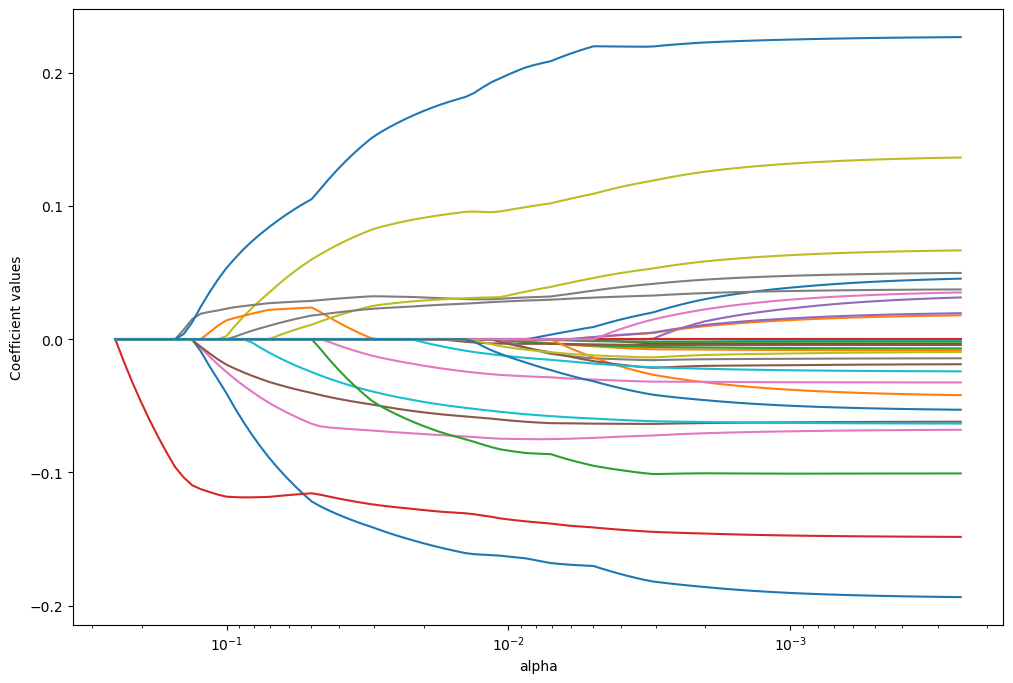

In [30]:
lasso_coefpath(reg_lasso, train_X_linear, train_Y_linear)

<Axes: xlabel='alpha', ylabel='Mean Squared error'>

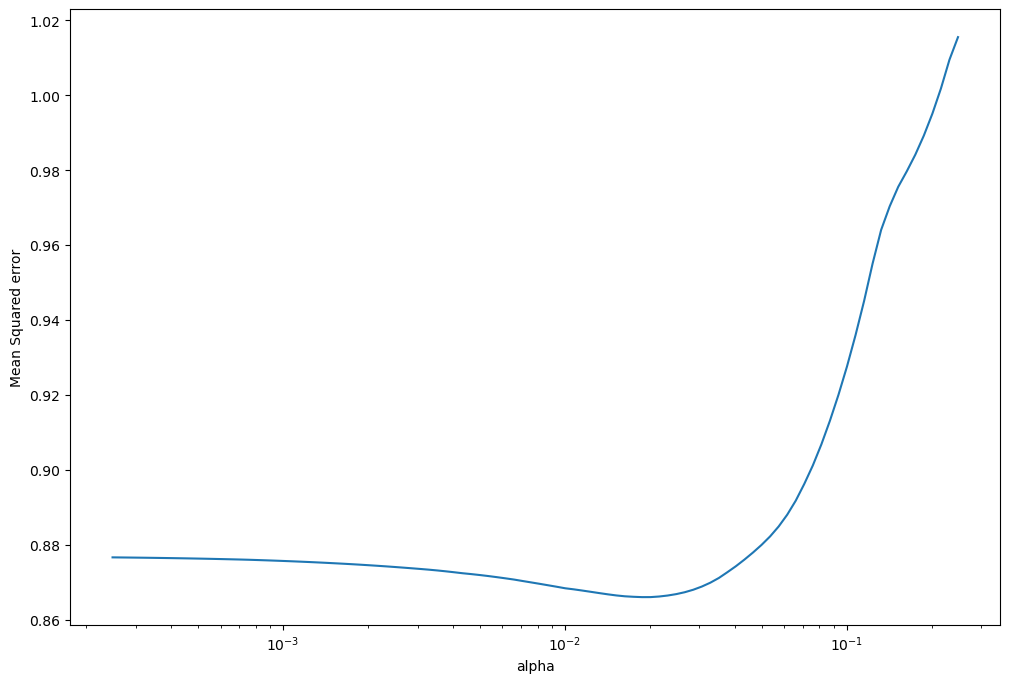

In [31]:
lasso_scorepath(reg_lasso, errorbars=False)

### Optimizing the LASSO parameter -- Logistic regression

The CV LASSO for logistic regression in scikit-learn is a bit more flexible than the linear LASSO.  In particular, this funciton allows us to specify what score we would like to use for optimization.  If the `scoring=` parameter is left off, it will default to accuracy.  However, since we are using ROC AUC for measuring performance, we can specify that instead using `scoring="roc_auc"`.  A full list of scoring functions is [available here](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values).

In [32]:
reg_lasso = linear_model.LogisticRegressionCV(penalty='l1', solver='saga', Cs=10, cv=5, scoring="roc_auc")
reg_lasso.fit(train_X_logistic, train_Y_logistic)
print('The C that optimizes ROC AUC is: {}'.format(reg_lasso.C_))

The C that optimizes ROC AUC is: [2.7825594]


<Axes: title={'center': 'Coefficient Plot'}, xlabel='Fitted value', ylabel='Residual'>

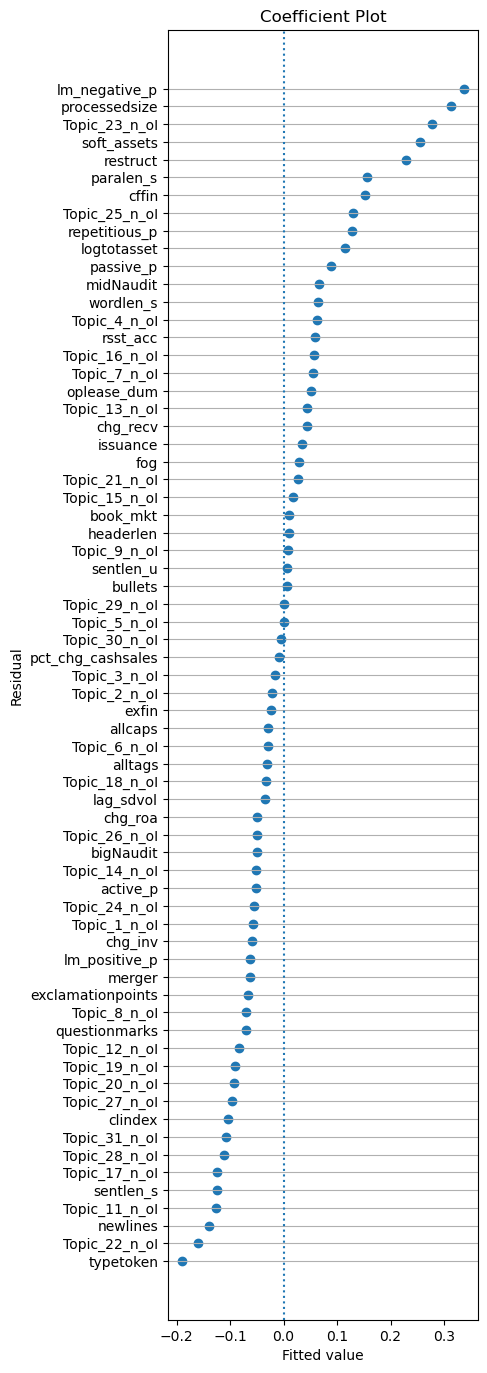

In [33]:
coefplot(vars, reg_lasso.coef_)

<Axes: xlabel='C', ylabel='Coefficient values'>

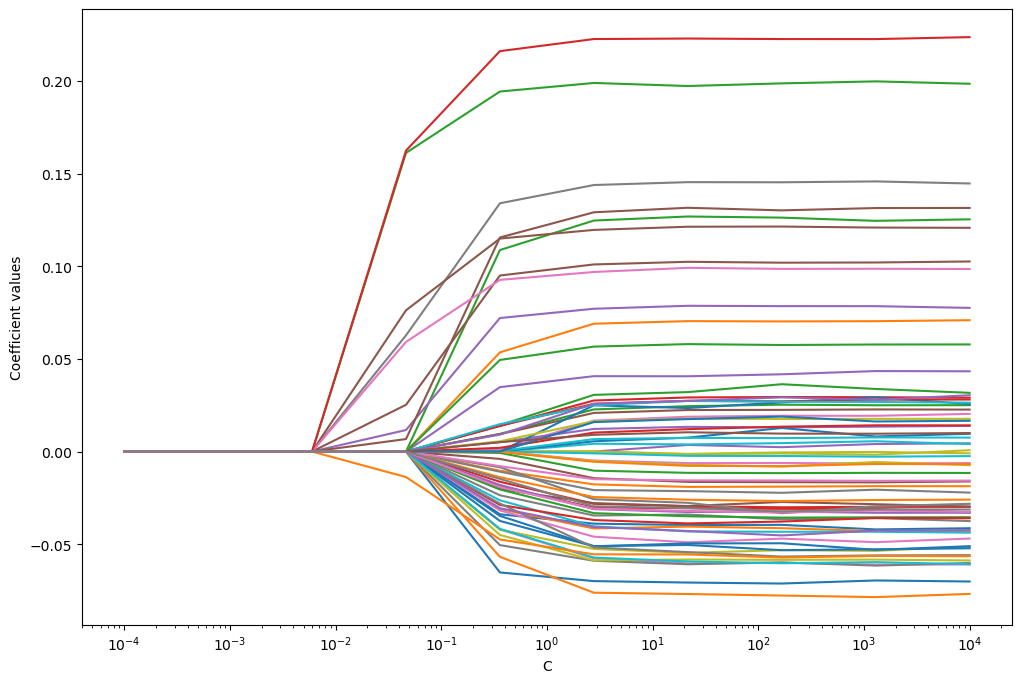

In [34]:
lasso_coefpath(reg_lasso, train_X_logistic, train_Y_logistic)

<Axes: xlabel='C', ylabel='ROC AUC'>

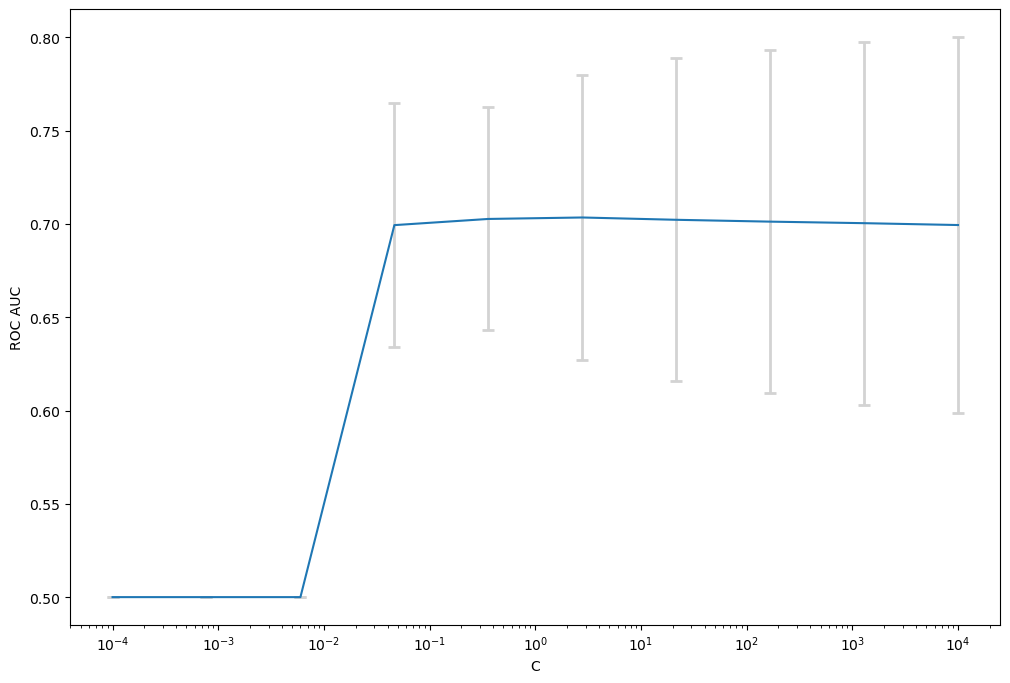

In [35]:
lasso_scorepath(reg_lasso)

## Elastic nets with cross validation

Once you have the hang of LASSO, branching out to elastic net or ridge is very straightforward, as the functions for these follow more-or-less the same format.  The only addition is needing to specify levels for `l1_ratio`: 1 is LASSO, 0 is Ridge, and any value in-between is elastic net.  You can specify a list of values and let the cross-validation figure out which is best.

### CV elastic net for OLS regression

In [36]:
reg_EN = linear_model.ElasticNetCV(cv=10, l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
reg_EN.fit(train_X_linear, np.ravel(train_Y_linear))
print('Optimal R^2 at l1_ratio of {} and alpha of {:.4f}'.format(reg_EN.l1_ratio_,reg_EN.alpha_))

Optimal R^2 at l1_ratio of 0.5 and alpha of 0.0376


<Axes: title={'center': 'Coefficient Plot'}, xlabel='Fitted value', ylabel='Residual'>

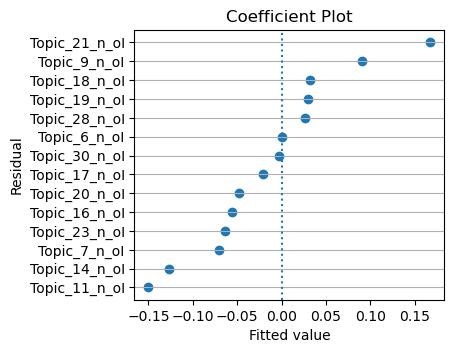

In [37]:
coefplot(vars, reg_EN.coef_)

### CV elastic net for logistic regression

In [38]:
reg_EN = linear_model.LogisticRegressionCV(
  penalty='elasticnet', solver='saga', Cs=5, cv=5,
  scoring="roc_auc", l1_ratios=[.96, .97, .98, .99, 1])
reg_EN.fit(train_X_logistic, train_Y_logistic)

print('ROC AUC is optimized at an l1_ratio of {} and a C of : {:.4f}'.format(reg_EN.l1_ratio_[0], reg_EN.C_[0]))

ROC AUC is optimized at an l1_ratio of 0.96 and a C of : 1.0000


<Axes: title={'center': 'Coefficient Plot'}, xlabel='Fitted value', ylabel='Residual'>

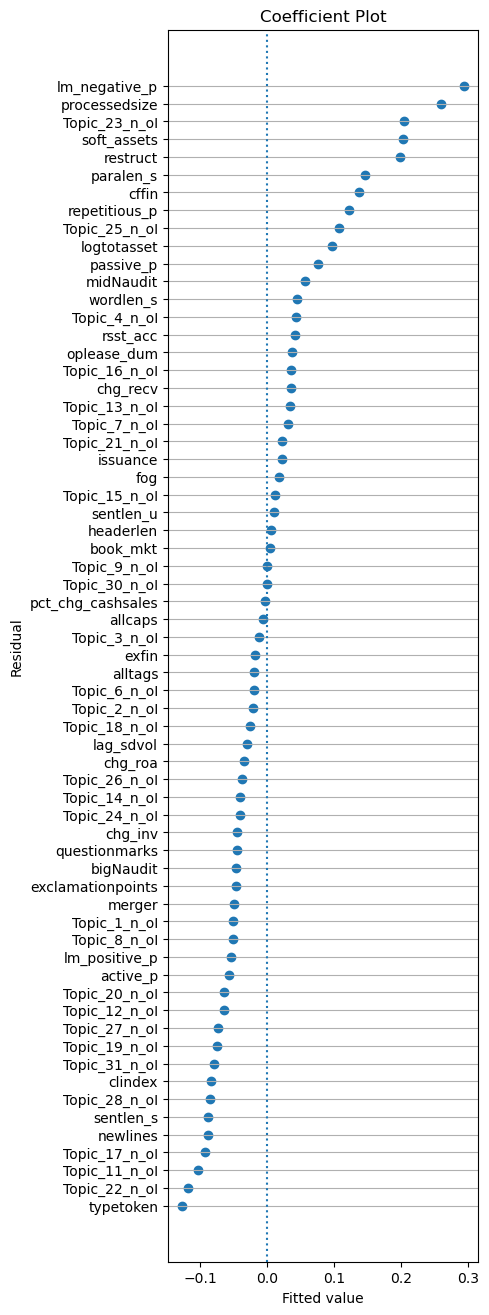

In [39]:
coefplot(vars, reg_EN.coef_)

### Final step: Comparing out of sample performance -- Logistic regression

M:\Python_environments\miniconda\envs\MLSS\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


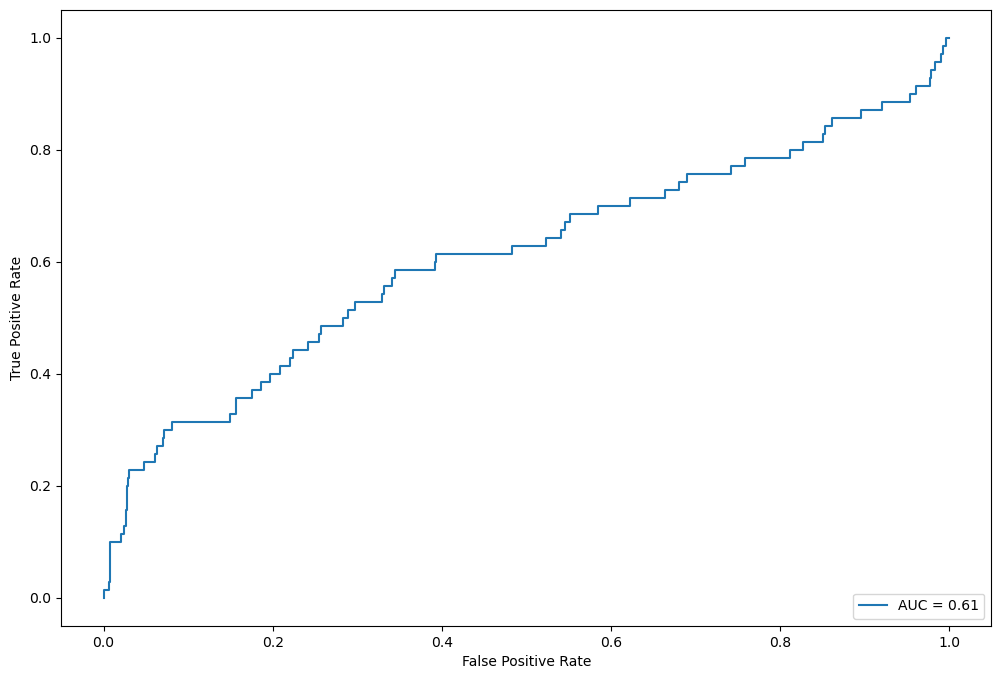

In [40]:
# Logistic regression
Y_hat_test = fit_logit.predict(test)
auc_logit = metrics.roc_auc_score(test.Restate_Int, Y_hat_test)
fpr_logit, tpr_logit, thresholds_logit = metrics.roc_curve(test.Restate_Int, Y_hat_test)
display = metrics.RocCurveDisplay(fpr=fpr_logit, tpr=tpr_logit, roc_auc=auc_logit)
display.plot()

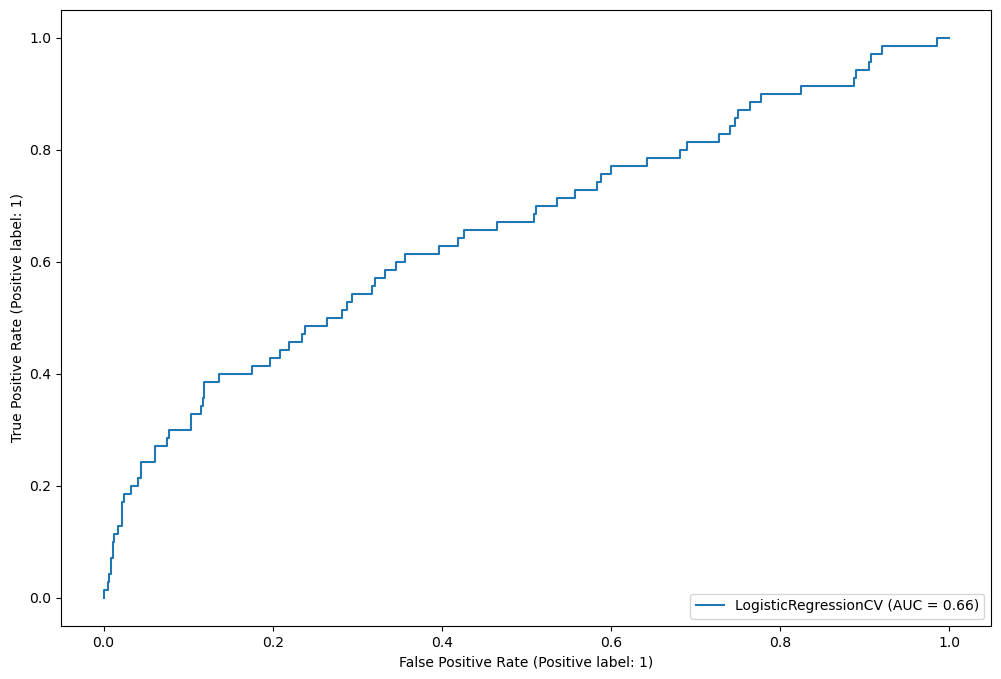

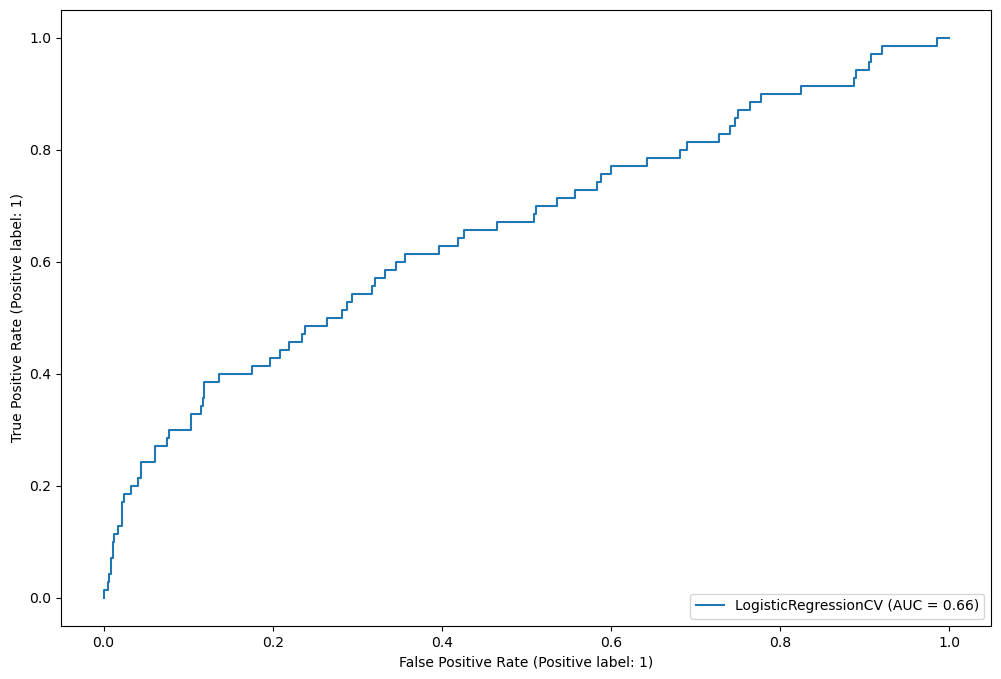

In [42]:
# LASSO
display = metrics.RocCurveDisplay.from_estimator(reg_lasso, test_X_logistic, test_Y_logistic)
display.plot()

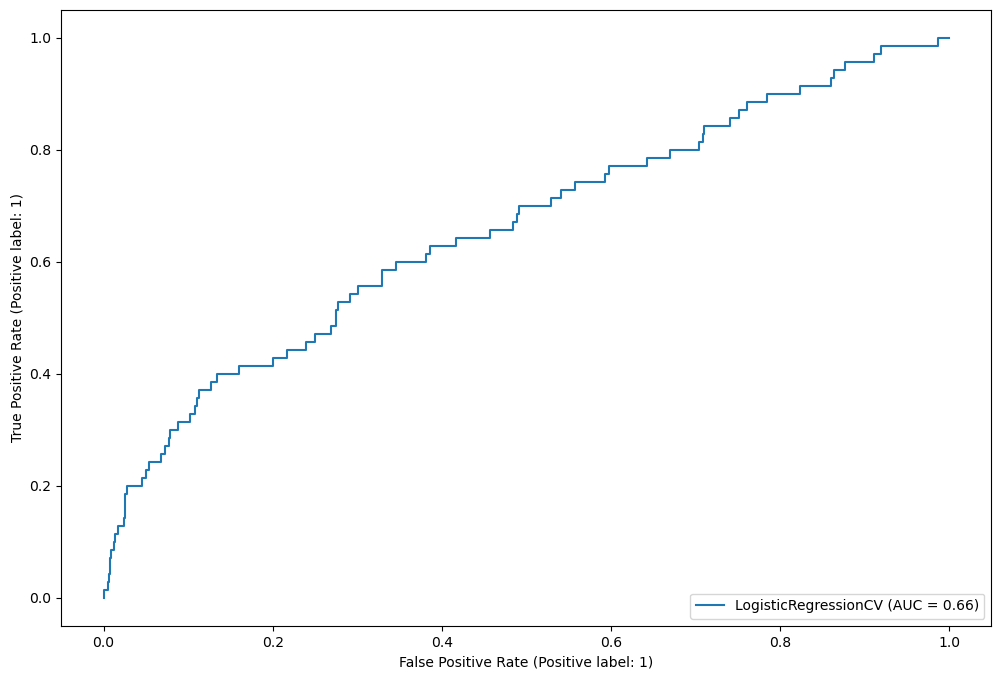

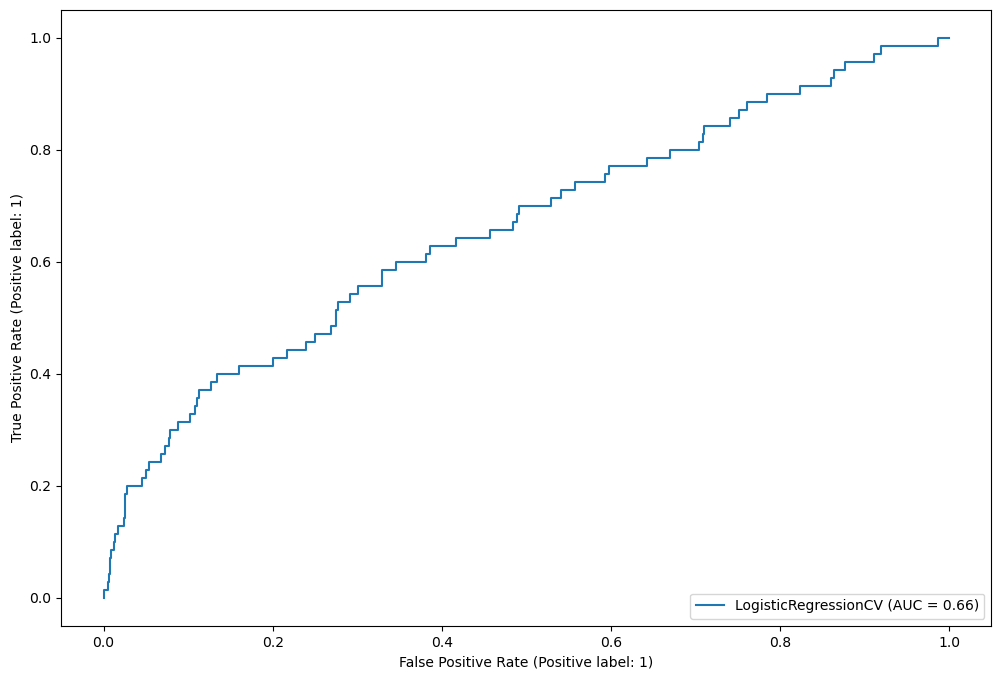

In [41]:
# Elastic Net
display = metrics.RocCurveDisplay.from_estimator(reg_EN, test_X_logistic, test_Y_logistic)
display.plot()

From the graphs, we can see that both elastic net and LASSO outperform logistic regression.  Both of these have comparable performance to one another, both with an AUC of 0.66.

In [43]:
with open('../../Data/S1_models.pkl', 'wb') as f:
    pickle.dump({'ElasticNet': reg_EN, 'LASSO': reg_lasso, 'logit': fit_logit, 'train_pd': train, 'test_pd': test, 'train_X_ML': train_X_logistic, 'test_X_ML': test_X_logistic, 'train_y': train_Y_logistic, 'test_y': test_Y_logistic, 'vars': vars}, f)